In [1]:
%load_ext autoreload

In [2]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
parent_folder_path = os.getenv('PARENT_FOLDER', '.')
sys.path.append(parent_folder_path)

In [3]:
%autoreload 2
from torchvision.transforms.v2.functional import grayscale_to_rgb
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import load_dataset
from dataset import get_elements_from_indexes, TRAIN_DATASET, LABELS
from libraries.segmentation.k_means import kmeans, KmeansFlags, KmeansTermCrit, KmeansTermOpt
import numpy as np
from libraries.common.histogram import img2hist, plot_hist
from matplotlib.widgets import EllipseSelector, RectangleSelector
import cv2
from libraries.improving.filtering import conv2d

In [4]:
%matplotlib widget
plt.ioff()

In [5]:
def draw_grayscale_image(image, ax, cmap='gray'):
    ax.imshow(image, cmap=cmap, vmin=0, vmax=255)
    ax.axis('off')

In [6]:
dataset_dic = load_dataset(**TRAIN_DATASET)

In [7]:
random_index = np.random.randint(len(dataset_dic))
element = get_elements_from_indexes(dataset_dic, random_index)[0]
image = element[0]
label = element[1]

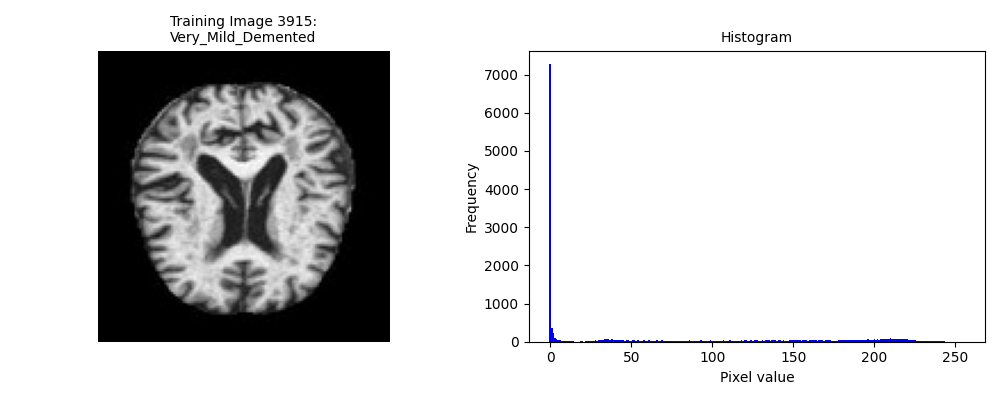

In [8]:
if 'fig_hist' in globals():
    plt.close('Figure & Histogram')
fig_hist, axs_hist = plt.subplots(1, 2, figsize=(10, 4), num='Figure & Histogram')
draw_grayscale_image(image, axs_hist[0])
axs_hist[0].set_title(f"Training Image {random_index}:\n{LABELS[label]}", fontsize=10)
image_hist = img2hist(image)
plot_hist(image_hist, **{'figure': fig_hist, 'ax': axs_hist[1], 
                         'color': 'b', 'show': False, 'title': None})
axs_hist[1].set_title(f"Histogram", fontsize=10)
fig_hist.tight_layout()
fig_hist.show()

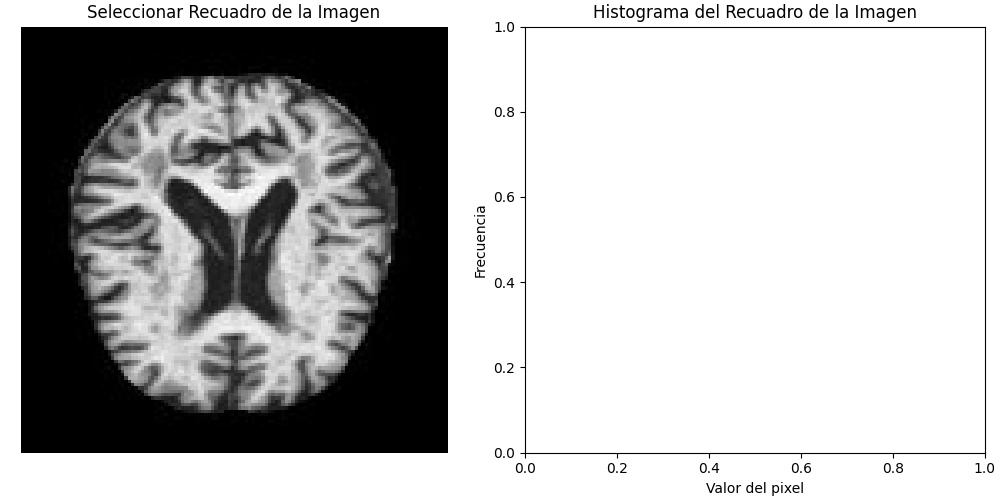

In [9]:
image_selection = None

def select_callback(eclick, erelease):
    global image_selection
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    if x1 is None or y1 is None or x2 is None or y2 is None:
        return
    image_selection = image[int(y1):int(y2), int(x1):int(x2)]
    image_selection_hist = img2hist(image_selection)
    axs_selection[1].clear()
    plot_hist(image_selection_hist, **{'title': 'Histograma del Recuadro de la Imagen',
                                  'xlabel': 'Valor del pixel',
                                  'ylabel': 'Frecuencia',
                                  'figure': fig_selection,
                                  'ax': axs_selection[1],
                                  'show': False})
    fig_selection.canvas.draw_idle()

if 'fig_selection' in globals():
    plt.close("Recuadro de la Imagen e Histograma")
fig_selection = plt.figure(layout='constrained', num="Recuadro de la Imagen e Histograma", figsize=(10, 5))
axs_selection = fig_selection.subplots(1, 2)
draw_grayscale_image(image, axs_selection[0])
axs_selection[0].set_title('Seleccionar Recuadro de la Imagen')
axs_selection[1].set_title('Histograma del Recuadro de la Imagen')
axs_selection[1].set_xlabel('Valor del pixel')
axs_selection[1].set_ylabel('Frecuencia')
selector = RectangleSelector(axs_selection[0], select_callback,
                             useblit=True,
                             button=[1, 3],  # disable middle button
                             minspanx=5, minspany=5,
                             spancoords='pixels',
                             interactive=True)
selector.set_active(True)
fig_selection.show()

In [10]:
print(np.std(image_selection))

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
# @title Filtro Gausiano {"run":"auto"}
epsilon = 0.1 # @param {"type":"slider","min":0.001,"max":0.1,"step":0.001}
# La imagen presenta ruido. Lo filtramos con un kernel gaussiano
sigma = 3
gaussianDim = int(np.ceil(np.sqrt(-2 * sigma ** 2 * np.log(epsilon * sigma * np.sqrt(2 * np.pi)))))
print(gaussianDim)
gaussianKernel1D = cv2.getGaussianKernel(gaussianDim, sigma)
gaussianKernel = np.outer(gaussianKernel1D, gaussianKernel1D)
filtered_image = conv2d(image, gaussianKernel)

3


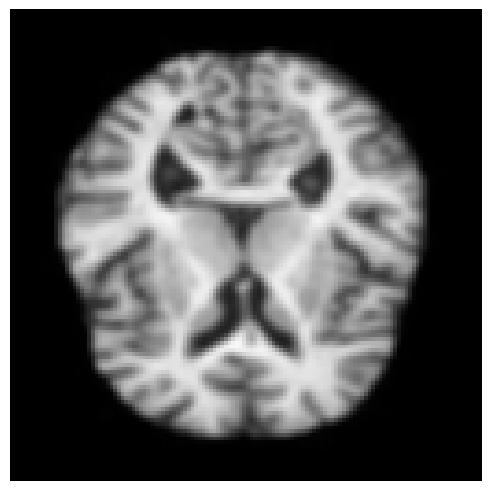

In [ ]:
if 'filtered_image_figure' in globals():
    plt.close('Imagen filtrada')
filtered_image_figure = plt.figure(num='Imagen filtrada', layout='constrained')
filtered_image_ax = filtered_image_figure.subplots(1,1)
draw_grayscale_image(filtered_image, filtered_image_ax)
filtered_image_figure

In [ ]:
compactness, labels, centers = kmeans(filtered_image.flatten(), 3, criteria=KmeansTermCrit(KmeansTermOpt.BOTH, 20, 0.5), flags=KmeansFlags.KMEANS_PP_CENTERS, attempts=5)
centers = centers.astype(np.uint8)
segmented_kmeans = centers[labels].reshape(image.shape)
sorted_centers = sorted(centers)
background_idx = np.argmax(centers == sorted_centers[0])
grey_matter_idx = np.argmax(centers == sorted_centers[1])
white_matter_idx = np.argmax(centers == sorted_centers[2])
segmented_white_matter = np.where(segmented_kmeans == centers[white_matter_idx], 1, 0)
segmented_grey_matter = np.where(segmented_kmeans == centers[grey_matter_idx], 1, 0)
segmented_background = np.where(segmented_kmeans == centers[background_idx], 1, 0)

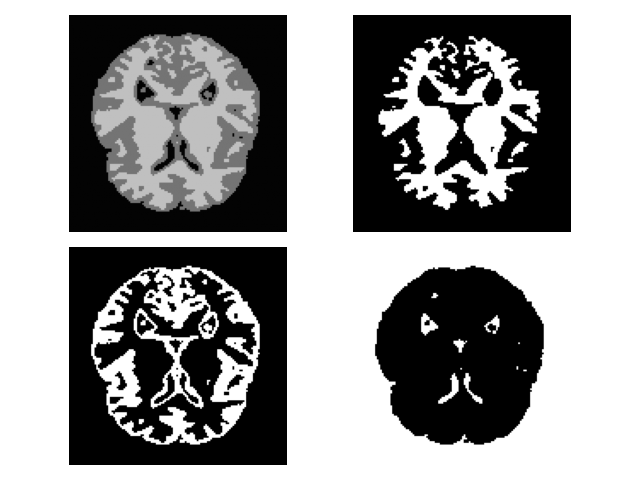

In [ ]:
if 'fig_kmeans' in globals():
    plt.close('Kmeans results')
fig_kmeans, axs_kmeans = plt.subplots(2, 2, num='Kmeans results')
draw_grayscale_image(segmented_kmeans, axs_kmeans[0][0])
draw_grayscale_image(segmented_white_matter * 255, axs_kmeans[0][1])
draw_grayscale_image(segmented_grey_matter * 255, axs_kmeans[1][0])
draw_grayscale_image(segmented_background * 255, axs_kmeans[1][1])
fig_kmeans.tight_layout()
fig_kmeans.show()

In [13]:
import os
import platform
from joblib import Parallel, delayed

import numpy as np
from numpy.typing import NDArray, ArrayLike
import cv2
import torch
from torch import nn
import torch.nn.functional as functional
from torchvision.models import efficientnet_b0
from datasets import load_dataset,  DatasetDict
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from dotenv import load_dotenv

from libraries.segmentation.k_means import kmeans, KmeansFlags, KmeansTermCrit, KmeansTermOpt
from libraries.improving.filtering import conv2d


# Load environment variables from .env file
load_dotenv()


MODEL_SD_FILE_NAME = os.path.join(parent_folder_path, 'model-service', 'model_cpu.pth')
TEST_DATASET = {'path': 'Falah/Alzheimer_MRI',
                'split': 'test'}
LABELS = {0: "Mild_Demented",
          1: "Moderate_Demented",
          2: "Non_Demented",
          3: "Very_Mild_Demented"}
PREDICTION_POWER_FILE_NAME = \
    os.environ.get('PREDICTION_POWER_NUMPY_FILE', 'prediction_power.npy')


def get_images_from_indexes(dataset: DatasetDict, indexes) -> list[NDArray]:
    """
    Get images from the dataset based on the provided indexes.
    Args:    
        dataset (DatasetDict): The dataset containing images.
        indexes (list): List of indexes to retrieve images from.
    Returns:
        list[NDArray]: A list of images as NumPy arrays.
    """
    list_images = []
    pillow_images = dataset[indexes]['image']
    if isinstance(pillow_images, list):
        for image in pillow_images:
            list_images.append(np.array(image))
    else:
        list_images.append(np.array(pillow_images))
    return list_images


def get_labels_from_indexes(dataset: DatasetDict, indexes) -> list[int]:
    """
    Get labels from the dataset based on the provided indexes.
    Args:
        dataset (DatasetDict): The dataset containing labels.
        indexes (list): List of indexes to retrieve labels from.
    Returns:
        list[int]: A list of labels corresponding to the images.
    """
    labels: list[int] | int = dataset[indexes]['label']
    if isinstance(labels, list):
        return labels
    elif isinstance(labels, int):
        # If a single label is returned, wrap it in a list
        return [labels]
    else:
        raise ValueError(f"Labels must be a list or an integer, got: {type(labels)}")


def get_elements_from_indexes(dataset: DatasetDict, indexes) -> list[NDArray]:
    """
    Get elements (images and labels) from the dataset based on the provided indexes.
    Args:
        dataset (DatasetDict): The dataset containing images and labels.
        indexes (list): List of indexes to retrieve elements from.
    Returns:
        list[(NDArray, int)]: A list of tuples, each containing an image
        and its corresponding label.
    """
    list_elements = []
    list_images = get_images_from_indexes(dataset, indexes)
    list_labels = get_labels_from_indexes(dataset, indexes)
    for image, label in zip(list_images, list_labels):
        list_elements.append((image, label))
    return list_elements


def setup_device():
    """
    Set up the device for PyTorch based on the system configuration.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif platform.system() == "Windows":
        try:
            import torch_directml
            device = torch_directml.device()
        except ImportError:
            device = torch.device("cpu")
    elif platform.system() == "Darwin":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    else:
        device = torch.device("cpu")
    return device


def get_classification_layer_efficientnet(in_channels=1280, out_channels=1000):
    """
    Create a classification layer for EfficientNet models.
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output classes.
    Returns:
        nn.Sequential: A sequential model containing the classification layer.
    """
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(in_features=in_channels, out_features=out_channels),
    )


class CustomEfficientNetB0Inference(nn.Module):
    """
    Custom EfficientNetB0 model for image classification.
    This model uses EfficientNetB0 as the backbone and adds a custom classification layer.
    """
    def __init__(self):
        super().__init__()
        self.skeleton =  nn.Sequential(*list(efficientnet_b0(weights=None).children())[:-1])
        self.classifier = get_classification_layer_efficientnet(1280, 4)
    def forward(self, input):
        """Execute the forward pass of the model."""
        return self.classifier(self.skeleton(input))


class MainModelInference(nn.Module):
    """Main model for inference."""
    def __init__(self):
        super().__init__()
        self.device = setup_device()
        self.net = CustomEfficientNetB0Inference().to(self.device)  # Changed this line
        self.input = None
        self.prediction = None
    def set_requires_grad(self, requires_grad=True):
        """Set the requires_grad attribute for all parameters in the model."""
        for p in self.net.parameters():
            p.requires_grad = requires_grad
    def setup_input(self, data):
        """Set up the input tensor for the model."""
        if isinstance(data, list):
            data = np.stack(data)
        elif isinstance(data, np.ndarray):
            pass
        else:
            data = np.array(data)
        if data.ndim == 3:
            data = np.expand_dims(data, axis=0)
        self.input = torch.from_numpy(data).float().to(self.device)
    def forward(self):
        """Execute the forward pass of the model."""
        self.prediction = self.net(self.input)


def build_and_load_model_from_state(path: str = MODEL_SD_FILE_NAME):
    """
    Build and load the model from a saved state dictionary.
    """
    model = MainModelInference()
    model.load_state_dict(torch.load(path, weights_only=True))
    return model


def iter_list(func):
    """Decorator to apply a function to each element in a list."""
    def wrapper(lst, *args, **kwargs):
        if not isinstance(lst, list):
            return func(lst, *args, **kwargs)
        results = []
        for element in lst:
            results.append(func(element, *args, **kwargs))
        return np.stack(results)
    return wrapper


@iter_list
def pre_process_image(image_array: NDArray) -> NDArray:
    """
    Pre-process the input image by applying Gaussian filtering and K-means segmentation.
    Args:
        image_array (ArrayLike): Input image as a NumPy array.
    Returns:
        NDArray: A tuple containing the normalized image, segmented white matter,
        and segmented grey matter.
    """
    epsilon = 0.1
    sigma = 3
    gaussian_dim = int(np.ceil(np.sqrt(-2 * sigma ** 2 * \
                        np.log(epsilon * sigma * np.sqrt(2 * np.pi)))))
    gaussian_kernel1_d = cv2.getGaussianKernel(gaussian_dim, sigma)
    gaussian_kernel = np.outer(gaussian_kernel1_d, gaussian_kernel1_d)
    filtered_image = conv2d(image_array, gaussian_kernel)
    _, labels_kmeans, centers = kmeans(
        filtered_image.flatten(), 3,
        criteria=KmeansTermCrit(KmeansTermOpt.BOTH, 20, 0.5),
        flags=KmeansFlags.KMEANS_PP_CENTERS, attempts=5
    )
    centers = centers.astype(np.uint8)
    segmented_kmeans = centers[labels_kmeans].reshape(image_array.shape)
    sorted_centers = sorted(centers)
    white_matter_idx = np.argmax(centers == sorted_centers[2])
    grey_matter_idx = np.argmax(centers == sorted_centers[1])
    segmented_white_matter = \
        np.where(segmented_kmeans == centers[white_matter_idx], 1, 0).astype(np.float64)
    segmented_grey_matter = \
        np.where(segmented_kmeans == centers[grey_matter_idx], 1, 0).astype(np.float64)
    image_array = image_array.astype(np.float64) / 255
    return np.array((image_array, segmented_white_matter, segmented_grey_matter))


def predict(model: MainModelInference, input_vec: NDArray) -> NDArray:
    """
    Predict the class of the input vector using the model.
    Args:
        model (MainModelInference): The model to use for prediction.
        input_vec (ArrayLike): The input vector to classify.
    Returns:
        NDArray: The predicted class labels.
    """
    with torch.no_grad():
        model.setup_input(input_vec)
        model.forward()
    predicted = np.argmax(functional.softmax(model.prediction.detach().cpu(), dim=1), axis=1)
    return predicted.numpy()


def load_test_dataset() -> tuple[list[NDArray], NDArray]:
    """
    Load the test dataset and return images and labels.
    Returns:
        tuple[list[NDArray], NDArray]: A tuple containing a list of images and an array of labels.
    """
    dataset_dict = load_dataset(**TEST_DATASET)
    sample_indexes = np.arange(len(dataset_dict))
    sample = get_elements_from_indexes(dataset_dict, sample_indexes)
    images = [element[0] for element in sample]
    labels = np.array([element[1] for element in sample])
    return images, labels


def get_predictive_power(image_classifier: MainModelInference,
                         images: list[NDArray],
                         labels: NDArray) -> tuple[NDArray, NDArray]:
    """Get the predictive power of the model on a test dataset."""
    inputs = Parallel(n_jobs=8)(delayed(pre_process_image)(element) for element in tqdm(images))
    prediction = predict(image_classifier, inputs)
    prediction = np.array(prediction)
    correctly_classified = np.array([np.sum((labels == i) & (prediction == i)) for i in range(4)])
    total_per_class = np.array([np.sum(prediction == i) for i in range(4)])
    predictive_power = correctly_classified / total_per_class
    return prediction, predictive_power

In [14]:
test_images, test_labels = load_test_dataset()
classifier = build_and_load_model_from_state()

In [19]:
# Sample 5 images of each class
sample_indexes = []
for label in range(4):
    indexes = np.where(test_labels == label)[0]
    sample_indexes.extend(np.random.choice(indexes, size=5, replace=False))
sample_labels = test_labels[sample_indexes]
sample_images = [test_images[i] for i in sample_indexes]

In [20]:
sample_inputs = Parallel(n_jobs=8)(delayed(pre_process_image)(element) for element in tqdm(sample_images))
sample_prediction = predict(classifier, sample_inputs)
sample_report = classification_report(sample_labels, sample_prediction)
print(sample_report)

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.89        20
weighted avg       0.92      0.90      0.89        20



In [22]:
# Save images to the folder "example-images" with the following format:
# {index}_{class_label}_{right/wrong}.png
to_save_folder = os.path.join(parent_folder_path, 'example-images')
if not os.path.exists(to_save_folder):
    os.makedirs(to_save_folder)
for i, (image, label, prediction) in enumerate(zip(sample_images, sample_labels, sample_prediction)):
    right_or_wrong = 'right' if label == prediction else 'wrong'
    file_name = f"{i}_{LABELS[label]}_{right_or_wrong}.png"
    file_path = os.path.join(to_save_folder, file_name)
    cv2.imwrite(file_path, image)
    print(f"Saved {file_path}")

Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\0_Mild_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\1_Mild_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\2_Mild_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\3_Mild_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\4_Mild_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\5_Moderate_Demented_right.png
Saved c:\Users\Josue\Documents\Github Repositories\Biomedical-Image-Processing-Final-Assignment\example-images\6_Moderate_Demented_wrong.png
Saved c:\Users\Josue\Documents\Gi